# Coding Exercise: Domain Adaption Meta Learning

For this tutorial, we will be showcasing use of Domain Adaption Meta Learning, to learn a simple curve of sinusoidal data. It's a variation of 'Model Agnostic Meta Learning', but with added prior information i.e; extra relevant information about domain is already added.

Let's Begin!!!!

Meta-learning algorithms optimize the ability of models to learn new tasks quickly. To do so, they use data collected across a wide range of tasks and are evaluated based on their ability to learn new meta-test tasks. This process can be formalized as learning a prior(extract important information) over data(range of tasks), and the fine-tuning process becomes the inference under the learned prior. [Source, DAML paper]

<img src="Images/DAML.png" width="500"/>


#### Step 1: Import all libraries 

In [1]:
import math
import random
import sys
import torch # v0.4.1
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from time import sleep
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 2: Create a simple neural network architecture, which is going to learn the sinusoidal curve.
As mentioned above, we will be getting randomly generated data of sinusoidal curve so, we will be using this very small network, as we don't need a big one to learn a curve.

In [2]:
def meta_net(x, params): 
    # main network which is suppose to learn our main objective i.e; learn sinusoidal curve family here.
    x = F.linear(x, params[0], params[1])
    x1 = F.relu(x)

    x = F.linear(x1, params[2], params[3])
    x2 = F.relu(x)

    y = F.linear(x2, params[4], params[5])

    return y, x2, x1

params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

##### Step 3: Create another simple neural network architecture, for collecting and adding prior information about domain.
As mentioned above, we will be adding a prior knowledge to our main net. Therefore, we need to create a simple adap_net.

In [3]:
def adap_net(y, x2, x1, params): 
    # the net takes forward pass from meta_net and provides efficient parameter initializations i.e;
    # It works adapts the meta_net easily to any form of change
    
    x = torch.cat([y, x2, x1], dim=1)

    x = F.linear(x, params[0], params[1])
    x = F.relu(x)

    x = F.linear(x, params[2], params[3])
    x = F.relu(x)

    x = F.linear(x, params[4], params[5])

    return x

adap_params = [
    torch.Tensor(32, 1+32+32).uniform_(-1./math.sqrt(65), 1./math.sqrt(65)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

#### step 4: set up parameters for training
so as we are going to use inner loop vs outer loop training as mentioned in DAML paper. thus, we need to set certain parameters such as alpha, beta, learning rate, optimizer, and number of loops. 

In [4]:
opt = torch.optim.SGD(params + adap_params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2

#### Step 5: Implement Optimization Algorithm 
As mentioned in paper, this approach can learn new skill from only one video of a human. For this, it first trains to build a strong and rich prior over tasks during a meta-training phase, using both human demonstrations and teleoperated demonstrations are available.

In this phase, the robot(meta_net) learns "how to learn from humans" using data. After the meta-training phase, the robot can acquire new skills by combining its learned prior knowledge with one video of a human performing the new skill.


This approach consists of two phases. 
(i) In the metatraining phase, the goal will be to acquire a prior over policies(phi) using both human and robot demonstration data.

(ii) Use learned prior to quickly learn to imitate new tasks with only few data points. 

Note: adap_net works something similar to lstm meta learner, it provides info for main network in terms of parameters to converge faster and better. It provides new parameters after parsing through data.


In [5]:
inner_loop_loss=[]
outer_lopp_loss=[]

# Here, T ∼ p(T ) {or minibatch of tasks} is to learn sinusoidal family curves

with tqdm(total=100000, file=sys.stdout) as pbar:
    for it in range(100000):
        b = 0 if random.choice([True, False]) else math.pi
        #### Randomly obtain the task 2 sinusoidal data ####
        
        # Sample robotic task data d_r~D_r
        v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi 
        v_y = torch.sin(v_x + b)

        opt.zero_grad()

        new_params = params
        for k in range(n_inner_loop):
            # Sample Human task data d_h~D_h
            sampled_data = torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) 
                                               if b == 0 else random.uniform(-math.pi/2, -math.pi/4)]])
            
            # Here, si is adap_net parameters: adap_params and theta is meta_net parameters: new_params
            f, f2, f1 = meta_net(sampled_data, new_params) 
            h = adap_net(f, f2, f1, adap_params)
            
             # calculate loss
            adap_loss = F.l1_loss(h, torch.zeros(1, 1))
            grads = torch.autograd.grad(adap_loss, new_params, create_graph=True)
            
            # Compute policy parameters phi_t(new_params)
            new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

            if it % 100 == 0: 
                inner_loop_loss.append(adap_loss)

        v_f, _, _ = meta_net(v_x, new_params) # forward pass using learned policy parameters phi_t
        loss = F.l1_loss(v_f, v_y) # calculate the loss of meta_net
        loss.backward()
        
        opt.step() # optimize the policy parameters(theta and si)
        pbar.update(1)
        if it % 100 == 0: 
            outer_lopp_loss.append(loss)
            # print ('Iteration %d -- Outer Loss: %.4f' % (it, loss)) 


100%|██████████| 100000/100000 [12:45<00:00, 130.68it/s]


#### Step 5: Fine-tune our main net 
Once we have obtained right parameters, we will first generate some random data points to sub-sample 5 data points, and fine-tune main 'meta_net' using loss of adap_net. 

When deployed, the robot can adapt to a particular task with novel objects using just a single video of a human performing the task with those objects

In [6]:
t_b = math.pi
opt.zero_grad()
t_params = params

for k in range(n_inner_loop):
    # sample the new task data
    new_task_data = torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2)
                                        if t_b == 0 else random.uniform(-math.pi/2, -math.pi/4)]])
    # forward pass through meta_net to extract the input for adap_net
    t_f, t_f2, t_f1 = meta_net(new_task_data, t_params)
    # extract the information from adap_net
    t_h = adap_net(t_f, t_f2, t_f1, adap_params)
    # calculate the loss, here we used true label as torch.zeros(1, 1), because t_b = pi
    t_adap_loss = F.l1_loss(t_h, torch.zeros(1, 1))

    grads = torch.autograd.grad(t_adap_loss, t_params, create_graph=True)
    # learn the policy using the loss of adap_net
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

##### Step 6: Visualize outputs 

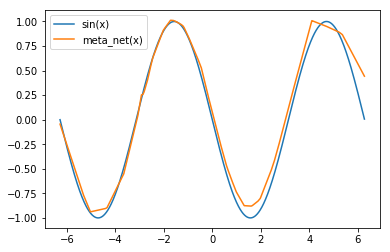

In [7]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f, _, _ = meta_net(test_x, t_params) # use the learned parameters

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='meta_net(x)')
plt.legend()
plt.savefig('daml-sine.png')

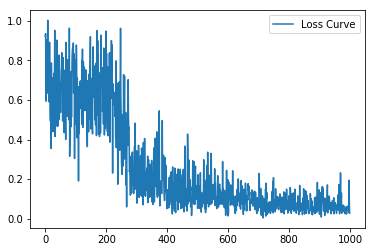

In [8]:
def plot_loss(inner_loop_loss,name="Loss Curve"):
    plt.plot(inner_loop_loss, label=name)
    plt.legend()
plot_loss(outer_lopp_loss)